In [43]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import correlation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings('ignore')

In [2]:
interaction_data = pd.read_parquet('data/interaction_data.parquet')
user_data = pd.read_parquet('data/user_data.parquet')

In [9]:
user_data.head()

,user_id,name,email,age,gender,subscription_plan,subscription_start_date
0,a100ec3a-5f27-4fb5-a561-c73f4db3caae,Peter Davis MD,gbranch@example.net,19,F,Basic,2022-04-05
1,9ceb0c77-917e-4459-91e6-c350f4dfed82,Michael Walker,tstewart@example.com,34,M,Premium,2022-07-17
2,0f7fc1df-a007-4dc1-b2b4-7bdfec14a9de,Richard Peterson,lindarobinson@example.com,70,M,Premium,2020-05-12
3,9514fdda-25d2-4266-8d01-dd6618293458,Anthony Khan,lramos@example.net,36,M,Premium,2021-06-08
4,780e7a54-2b94-461b-823d-73723bf31e6e,Paul Wiggins,greermadeline@example.com,58,F,Standard,2020-12-17


# 1. Exploratory Data Analysis

In [11]:
# Explore user_data
print(user_data.head())
print(user_data.describe())

                                user_id              name  \
0  a100ec3a-5f27-4fb5-a561-c73f4db3caae    Peter Davis MD   
1  9ceb0c77-917e-4459-91e6-c350f4dfed82    Michael Walker   
2  0f7fc1df-a007-4dc1-b2b4-7bdfec14a9de  Richard Peterson   
3  9514fdda-25d2-4266-8d01-dd6618293458      Anthony Khan   
4  780e7a54-2b94-461b-823d-73723bf31e6e      Paul Wiggins   

                       email  age gender subscription_plan  \
0        gbranch@example.net   19      F             Basic   
1       tstewart@example.com   34      M           Premium   
2  lindarobinson@example.com   70      M           Premium   
3         lramos@example.net   36      M           Premium   
4  greermadeline@example.com   58      F          Standard   

  subscription_start_date  
0              2022-04-05  
1              2022-07-17  
2              2020-05-12  
3              2021-06-08  
4              2020-12-17  
              age
count  1000.00000
mean     48.76500
std      18.10999
min      18.00000
25

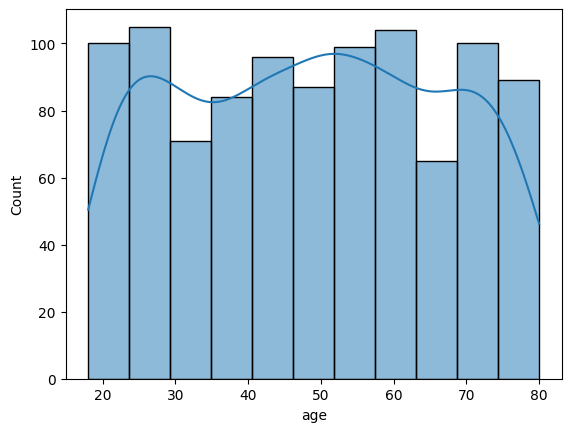

In [12]:
sns.histplot(user_data['age'], kde=True)
plt.show()

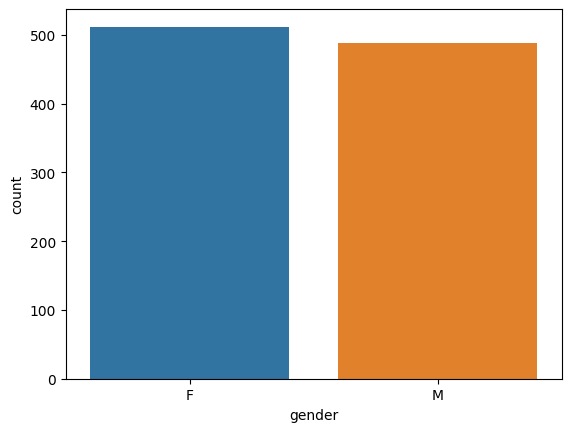

In [13]:
sns.countplot(x='gender', data=user_data)
plt.show()

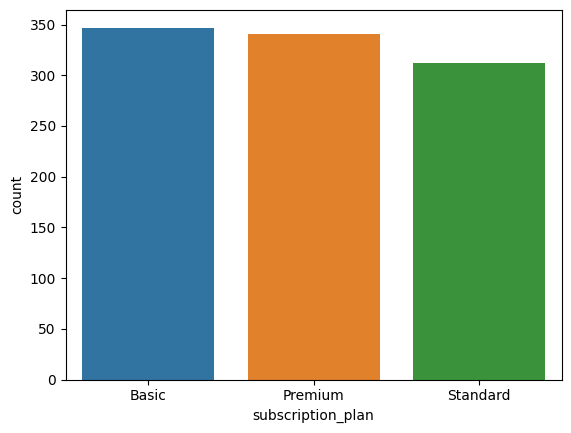

In [14]:
sns.countplot(x='subscription_plan', data=user_data)
plt.show()


In [15]:
# Explore interaction_data
print(interaction_data.head())
print(interaction_data.describe())


                                user_id                            content_id  \
0  c1fd747e-699d-4a48-95c4-cc5200bfc2ed  1a6947dd-efa0-4199-9a76-687cd0d616ff   
1  7eb91075-0a70-43c3-9f4a-916cbcbca0d0  84ec5e1a-c3a0-414c-a7cd-f59e6a07681b   
2  fb5b9a29-db58-424c-af2f-3ed438a8c2df  6b024f86-7b0f-46b0-96e6-5042a78db2eb   
3  01f43a6c-205a-4390-a020-7dd945bf8c0e  75ada412-0e22-4aa2-9b18-03e42f23e3da   
4  2ea30ab5-4992-4616-bebd-28ebd0488af5  e190b376-c77b-47ce-a667-6d97a666a296   

                                       content_title content_category  \
0                                Head far true draw.          TV Show   
1  Time always out church real under society ground.  Stand-up Comedy   
2                       Pressure course player make.            Movie   
3             Develop nearly sing stop wrong region.            Movie   
4                      Eat available charge instead.      Documentary   

     genre  watch_date  rating  session_duration  
0   Family  2022-10-04 

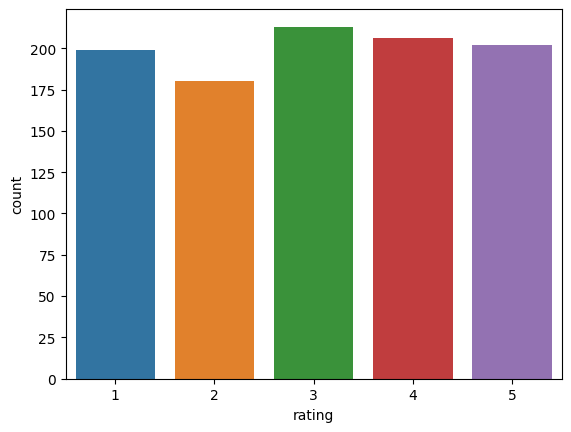

In [16]:
sns.countplot(x='rating', data=interaction_data)
plt.show()

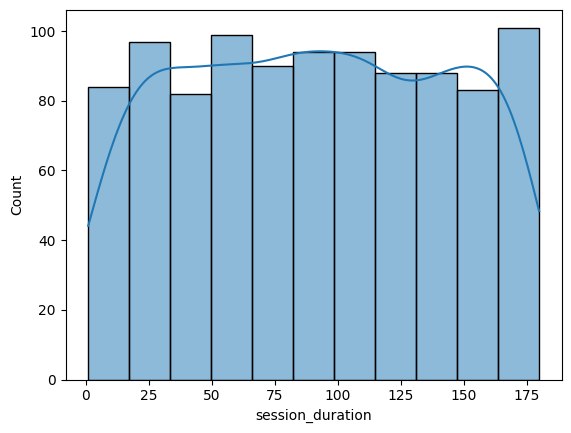

In [17]:
sns.histplot(interaction_data['session_duration'], kde=True)
plt.show()


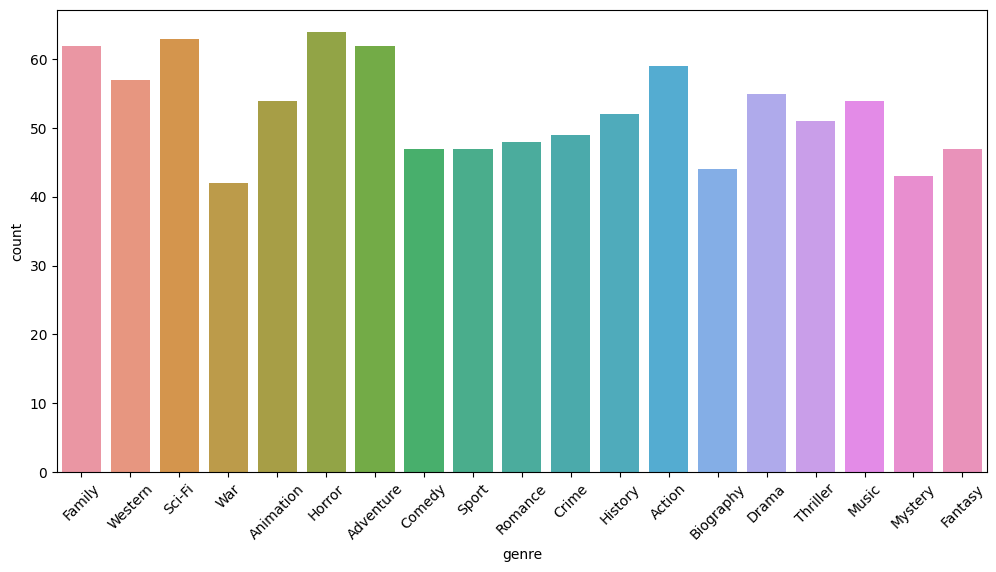

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(x='genre', data=interaction_data)
plt.xticks(rotation=45)
plt.show()

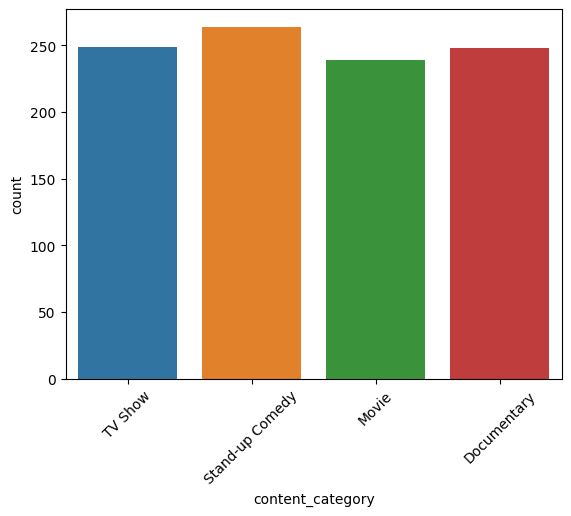

In [19]:
sns.countplot(x='content_category', data=interaction_data)
plt.xticks(rotation=45)
plt.show()

# 2. Feature Engineering

In [20]:
# Merge the user_data and interaction_data dataframes on the 'user_id'
combined_data = interaction_data.merge(user_data, on='user_id', how='left')

# Calculate the time since the user subscribed to the streaming service.
combined_data['subscription_start_date'] = pd.to_datetime(combined_data['subscription_start_date'])
combined_data['watch_date'] = pd.to_datetime(combined_data['watch_date'])

combined_data['subscription_duration'] = (combined_data['watch_date'] - combined_data['subscription_start_date']).dt.days

# Create dummy variables for categorical features like 'gender', 'subscription_plan', 'content_category', and 'genre'. 
combined_data = pd.get_dummies(combined_data, columns=['gender', 'subscription_plan', 'content_category', 'genre'], drop_first=True)

In [22]:
combined_data.head()

,user_id,content_id,content_title,watch_date,rating,session_duration,name,email,age,subscription_start_date,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
0,c1fd747e-699d-4a48-95c4-cc5200bfc2ed,1a6947dd-efa0-4199-9a76-687cd0d616ff,Head far true draw.,2022-10-04,3,127,Anthony Johnson,waltersullivan@example.com,38,2020-06-30,...,0,0,0,0,0,0,0,0,0,0
1,7eb91075-0a70-43c3-9f4a-916cbcbca0d0,84ec5e1a-c3a0-414c-a7cd-f59e6a07681b,Time always out church real under society ground.,2022-11-13,2,81,Lauren Carter,pcampbell@example.com,76,2022-11-15,...,0,0,0,0,0,0,0,0,0,1
2,fb5b9a29-db58-424c-af2f-3ed438a8c2df,6b024f86-7b0f-46b0-96e6-5042a78db2eb,Pressure course player make.,2022-06-29,4,148,Kaitlyn Delgado,andrew24@example.net,73,2022-02-28,...,0,0,0,0,0,1,0,0,0,0
3,01f43a6c-205a-4390-a020-7dd945bf8c0e,75ada412-0e22-4aa2-9b18-03e42f23e3da,Develop nearly sing stop wrong region.,2023-02-03,5,52,Robin Turner,ftaylor@example.org,24,2022-11-05,...,0,0,0,0,0,1,0,0,0,0
4,2ea30ab5-4992-4616-bebd-28ebd0488af5,e190b376-c77b-47ce-a667-6d97a666a296,Eat available charge instead.,2022-08-27,2,111,Dr. Jeffrey Price,mikerodriguez@example.com,44,2023-04-06,...,0,0,0,0,0,0,0,0,1,0


# 3. Data Preprocessing

In [26]:
# Create a user-item interaction matrix
interaction_matrix = pd.pivot_table(data=combined_data, values='rating', index='user_id', columns='content_id', fill_value=0)

# Calculate the similarity between users using the Pearson correlation coefficient
def pearson_similarity(matrix, user1, user2):
    user1_ratings = matrix.loc[user1]
    user2_ratings = matrix.loc[user2]
    common_items = (user1_ratings != 0) & (user2_ratings != 0)
    if common_items.sum() == 0:
        return 0
    user1_common_ratings = user1_ratings[common_items]
    user2_common_ratings = user2_ratings[common_items]
    return 1 - correlation(user1_common_ratings, user2_common_ratings)
    
# Find the top k similar users for a target user:
def top_k_similar_users(matrix, user, k=5):
    users = matrix.index.tolist()
    users.remove(user)
    similarities = [pearson_similarity(matrix, user, other_user) for other_user in users]
    top_k_users = sorted(zip(users, similarities), key=lambda x: x[1], reverse=True)[:k]
    return top_k_users


# 4. Model Selection

In [29]:
# Generate recommendations for the target user based on the top k similar users:
def user_based_recommendations(matrix, user, k=5):
    top_k_users = top_k_similar_users(matrix, user, k)
    user_ratings = matrix.loc[user]
    not_rated_items = user_ratings[user_ratings == 0].index
    weighted_sum = [0] * len(not_rated_items)
    
    for other_user, similarity in top_k_users:
        other_user_ratings = matrix.loc[other_user]
        
        for i, item in enumerate(not_rated_items):
            weighted_sum[i] += other_user_ratings[item] * similarity
            
    recommendations = sorted(zip(not_rated_items, weighted_sum), key=lambda x: x[1], reverse=True)
    
    return recommendations

user_id = 'c1fd747e-699d-4a48-95c4-cc5200bfc2ed'
k = 5
recommendations = user_based_recommendations(interaction_matrix, user_id, k)
print(recommendations)


[('006d6e2e-d687-4317-a8cc-d9042f43d427', 0), ('00863805-d2e8-4f57-94ff-02c2b7c827d4', 0), ('009ec179-ea5d-4cdd-a0ac-f3806701139e', 0), ('009fcd94-3103-4b19-ae5a-022879a8bc93', 0), ('00a74ef0-152c-49f1-b867-b4080d7ef839', 0), ('00af7aae-7066-431a-bff0-851a81a38d18', 0), ('00fbd013-6ceb-461e-9744-32d6856197c2', 0), ('01192766-fee4-4e06-afc2-6786eee95ad3', 0), ('015d8b5d-0a91-4eb7-a070-397607196ccc', 0), ('01b33a93-11ea-4faa-af5c-a9c2dc5388ae', 0), ('01c191fd-19ec-4e09-9a25-c03eebf71da4', 0), ('01f50968-36af-460c-b2c4-66b0fa535ebc', 0), ('0206cb88-6d7b-45fe-afa4-49dfb21d98c4', 0), ('0279ddc2-05e3-46d3-85c8-ac72947f3633', 0), ('0298f123-47b4-4d81-8be5-1897b672e6d5', 0), ('02b4453b-a2e5-46e1-99d8-14d50ee81036', 0), ('033a6b09-0f96-4a3a-9bf5-f7a3dd476c3a', 0), ('034f31dd-c807-4f44-83bb-daf018552dd3', 0), ('036ca2be-1a74-48ea-9c74-4ebf4e963fc1', 0), ('0388f077-acf9-4a4b-b415-ec704d4a1e52', 0), ('043cd77c-84a8-491e-9cca-d07d4ea9d81c', 0), ('049c04ef-6458-452f-8d7e-4e13b96ce738', 0), ('04ad50c

# 5. Conclusion
In this project, we have analyzed a streaming service provider's data to gain insights into user preferences and behavior, with the goal of providing personalized content and recommendations to improve customer retention.

**EDA (Exploratory Data Analysis)**: We started by exploring and visualizing the data using Pandas, which allowed us to understand the patterns, trends, and relationships within the data. We analyzed user demographics, content preferences, and viewing habits to get a better understanding of the user base and their preferences.

**Feature Engineering**: Based on our domain knowledge and understanding of the data, we created new features or modified existing ones to enhance the predictive power of our machine learning model. We used one-hot encoding for categorical variables and created new features that could help us better understand user preferences.

**Data Preprocessing**: We calculated the similarity between users using the Pearson correlation coefficient, for a target user, we found the top k similar users based on their similarity scores.

**Model Selection**: We chose appropriate machine learning algorithms based on the problem we were trying to solve and the characteristics of our data. In this case, we used User-based Collaborative Filtering to recommend content to users based on their preferences and viewing history.

Throughout the project, we have successfully explored, preprocessed, and built a recommendation system for a streaming service provider using machine learning techniques. This has allowed us to provide personalized recommendations and insights that can be used to improve customer retention and enhance the overall user experience.